In [0]:
!unzip spectrogram.zip

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cv2
import re
from keras.utils import to_categorical

Using TensorFlow backend.


### Loading the dataset

In [0]:

data_dir = '/content/spectrogram'

all_img = os.listdir(data_dir)
random.shuffle(all_img)


train_img = [data_dir+'/'+img for img in all_img[:1600]]
test_img = [data_dir+'/'+img for img in all_img[1600:]]


In [5]:
print(len(train_img), len(test_img))
print(train_img[:5])
print(test_img[:5])

1600 400
['/content/spectrogram/2_jackson_13.png', '/content/spectrogram/6_yweweler_32.png', '/content/spectrogram/4_nicolas_7.png', '/content/spectrogram/8_theo_31.png', '/content/spectrogram/7_yweweler_30.png']
['/content/spectrogram/2_yweweler_20.png', '/content/spectrogram/6_nicolas_39.png', '/content/spectrogram/0_theo_17.png', '/content/spectrogram/2_jackson_1.png', '/content/spectrogram/1_theo_5.png']


### Convert image into numpy array

In [ ]:

nrows = 64
ncols = 64
channel = 3

RE = r'(.*)([0-9]_.*)'
reobj = re.compile(RE)

def label_data(list_of_img):
    """
    Resizing image into (nrows,ncols) and converts it to a numpy array(4D).
    Returns the pixel values as a numpy array and the labels.
    OneHotEncoder used to convert labels to categorical data.
    """
    X = []
    y = []
    for image in list_of_img:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR),(nrows,ncols),interpolation=cv2.INTER_CUBIC))
        y.append(reobj.search(image).groups()[1][0])
    return np.array(X), to_categorical(y,num_classes=10)

X_train, y_train = label_data(train_img)
print(X_train.shape,type(y_train))
    
  

In [7]:
print(X_train.shape, type(y_train[0]))


(1600, 64, 64, 3) <class 'numpy.ndarray'>


### CNN model

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization


model = Sequential()

#Convoultion layers
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(64,64,3)))
model.add(BatchNormalization())

model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())

#Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Dense layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 1440 samples, validate on 160 samples
Epoch 1/30
1440/1440 [==============================] - 120s 83ms/step - loss: 1.4131 - acc: 0.5333 - val_loss: 0.4366 - val_acc: 0.8500
Epoch 2/30
1440/1440 [==============================] - 117s 81ms/step - loss: 0.5830 - acc: 0.8257 - val_loss: 0.3001 - val_acc: 0.9125
Epoch 3/30
1440/1440 [==============================] - 117s 81ms/step - loss: 0.3642 - acc: 0.9118 - val_loss: 0.2656 - val_acc: 0.9125
Epoch 4/30
1440/1440 [==============================] - 116s 81ms/step - loss: 0.2199 - acc: 0.9514 - val_loss: 0.2345 - val_acc: 0.9500
Epoch 5/30
1440/1440 [==============================] - 116s 81ms/step - loss: 0.1403 - acc: 0.9764 - val_loss: 0.1879 - val_acc: 0.9563
Epoch 6/30
1440/1440 [==============================] - 118s 82ms/step - loss: 0.1001 - acc: 0.9854 - val_loss: 0.1742 - val_acc: 0.9313
Epoch 7/30
1440/1440 [==============================] - 117s 81ms/step - loss: 0.07

### Testing the model

In [10]:
X_test, y_test = label_data(test_img)
pred = model.evaluate(X_test, y_test)
print(pred[0], pred[1])
print(model.metrics_names)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)



400/400 [==============================] - 8s 19ms/step
0.12247643603011965 0.975
['loss', 'acc']


### Evaluating the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 32)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 48)        6192      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 48)        192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 120)       23160     
_________________________________________________________________
batch_normalization_3 (Batch (None, 61, 61, 120)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 120)       0         
__________

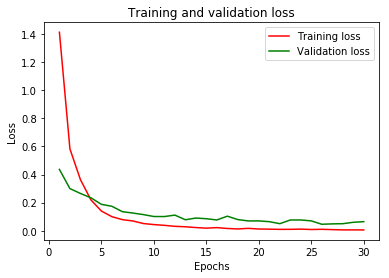

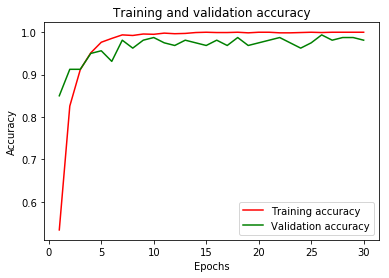

In [11]:
model.save('model_trained.h5')

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

model.summary()

#Training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(loss)+1)
plt.plot(epoch,loss, color='red', label='Training loss')
plt.plot(epoch, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png',dpi=100)
plt.show()


#Training and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = range(1,len(acc)+1)
plt.plot(epoch, acc, color='red', label='Training accuracy')
plt.plot(epoch, val_acc, color='green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_plot.png',dpi=100)
plt.show()



### Performance metrics

In [12]:
from sklearn.metrics import classification_report

predictions = model.predict_classes(X_test)
print(classification_report(y_test, to_categorical(predictions)))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.97      1.00      0.99        39
           2       1.00      1.00      1.00        48
           3       0.91      0.94      0.92        32
           4       1.00      1.00      1.00        23
           5       1.00      0.98      0.99        46
           6       0.98      0.91      0.94        46
           7       1.00      0.95      0.97        38
           8       0.94      0.98      0.96        46
           9       0.97      1.00      0.99        37

   micro avg       0.97      0.97      0.97       400
   macro avg       0.98      0.98      0.97       400
weighted avg       0.98      0.97      0.97       400
 samples avg       0.97      0.97      0.97       400

